import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [2]:
outcomePath = '/Users/justinholmes/Desktop/Sports_Model/Data/outcomeData.csv'
featurePath = '/Users/justinholmes/Desktop/Sports_Model/Data/featureData.csv'

In [3]:
outcomeData = pd.read_csv(outcomePath)
featureData = pd.read_csv(featurePath)

### Format all data

In [4]:
# drop unwanted columns
outcomeData = outcomeData.drop(["Start Time", "Box Score", "Notes"], axis=1)

In [5]:
# change OT to integer value for number of OT rounds
outcomeData.loc[(outcomeData["OT?"].isna()),'OT?']= 0
outcomeData.loc[(outcomeData["OT?"] == "OT"),'OT?']= 1
outcomeData.loc[(outcomeData["OT?"] == "2OT"),'OT?']= 2
outcomeData.loc[(outcomeData["OT?"] == "3OT"),'OT?']= 3
outcomeData.loc[(outcomeData["OT?"] == "4OT"),'OT?']= 4

In [6]:
def redefineTeamNames(dataframe):
    dataframe = dataframe.replace('Seattle SuperSonics', 'Oklahoma City Thunder', regex=True)
    
    dataframe = dataframe.replace('New Orleans/Oklahoma City Hornets', 'New Orleans Pelicans', regex=True)

    dataframe = dataframe.replace('New Orleans Hornets', 'New Orleans Pelicans', regex=True)
    
    dataframe = dataframe.replace('Charlotte Bobcats', 'Charlotte Hornets', regex=True)
    
    dataframe = dataframe.replace('New Jersey Nets', 'Brooklyn Nets', regex=True)
    
#     dataframe = dataframe.replace('*', '', regex=True)

    return dataframe

outcomeData = redefineTeamNames(outcomeData)

In [7]:
outcomeData["Final Home Spread"] = (outcomeData["VisitorPTS"] - outcomeData["HomePTS"]).astype(float)

In [8]:
outcomeData = pd.concat([outcomeData, featureData], axis=1, sort=False)

In [9]:
def homeWin(dataframe):
    if dataframe['Winner'] == dataframe['Home']:
        return True
    else:
        return False

# outcomeData['HomeWin'] = outcomeData.apply(homeWin, axis=1)

In [10]:
outcomeData.head()

,Year,Month,Visitor,VisitorPTS,Home,HomePTS,OT?,Attend,Total Points,Winner,...,3PAr,TS%,eFG%,TOV%,ORB%,FT/FGA,eFG%.1,TOV%.1,DRB%,FT/FGA.1
0,2005,november,Houston Rockets,79,Detroit Pistons,87,0,22076,166,Detroit Pistons,...,-0.073,-0.015,-0.014,-0.2,4.9,0.005,0.002,0.6,-1.5,-0.038
1,2005,november,Sacramento Kings,98,Dallas Mavericks,107,0,20041,205,Dallas Mavericks,...,-0.010,0.004,-0.004,0.5,-0.2,0.047,-0.021,1.0,1.2,0.025
2,2005,november,Denver Nuggets,78,Los Angeles Lakers,89,0,18997,167,Los Angeles Lakers,...,0.131,0.000,0.002,-0.4,1.1,-0.016,0.011,-4.1,-0.6,-0.029
3,2005,november,Indiana Pacers,109,Cleveland Cavaliers,104,2,19730,213,Indiana Pacers,...,-0.120,-0.016,-0.006,-1.1,6.1,-0.039,0.013,0.5,0.2,-0.013
4,2005,november,Milwaukee Bucks,92,Orlando Magic,93,0,15138,185,Orlando Magic,...,-0.004,0.002,0.003,1.6,0.9,0.004,-0.015,0.8,-0.7,0.022


In [11]:
encoding = LabelEncoder()
encoding.fit(outcomeData['Home'].values)
outcomeData['Home'] = encoding.transform(outcomeData['Home'].values)
outcomeData['Visitor'] = encoding.transform(outcomeData['Visitor'].values)

In [12]:
outcomeData = outcomeData.drop(['Month', 'Attend', 'Winner', 'VisitorPTS', 'HomePTS', 'Total Points'
                                ], axis=1)


In [13]:
outcomeData.head()

,Year,Visitor,Home,OT?,Final Home Spread,FG_PG,FGA_PG,FG%_PG,3P_PG,3PA_PG,...,3PAr,TS%,eFG%,TOV%,ORB%,FT/FGA,eFG%.1,TOV%.1,DRB%,FT/FGA.1
0,2005,10,8,0,-8.0,0.1,0.0,0.001,-2.3,-5.7,...,-0.073,-0.015,-0.014,-0.2,4.9,0.005,0.002,0.6,-1.5,-0.038
1,2005,25,6,0,-9.0,-1.8,-3.5,-0.002,-0.8,-1.5,...,-0.010,0.004,-0.004,0.5,-0.2,0.047,-0.021,1.0,1.2,0.025
2,2005,7,13,0,-11.0,-1.7,0.1,-0.022,4.0,10.6,...,0.131,0.000,0.002,-0.4,1.1,-0.016,0.011,-4.1,-0.6,-0.029
3,2005,11,5,2,5.0,4.0,6.3,0.015,-2.9,-8.2,...,-0.120,-0.016,-0.006,-1.1,6.1,-0.039,0.013,0.5,0.2,-0.013
4,2005,16,21,0,-1.0,0.9,1.3,0.004,-0.1,-0.1,...,-0.004,0.002,0.003,1.6,0.9,0.004,-0.015,0.8,-0.7,0.022


In [14]:
trainData = outcomeData.loc[outcomeData['Year'] < 2020]
testData = outcomeData.loc[outcomeData['Year'] == 2020]

In [15]:
trainData.head()

,Year,Visitor,Home,OT?,Final Home Spread,FG_PG,FGA_PG,FG%_PG,3P_PG,3PA_PG,...,3PAr,TS%,eFG%,TOV%,ORB%,FT/FGA,eFG%.1,TOV%.1,DRB%,FT/FGA.1
0,2005,10,8,0,-8.0,0.1,0.0,0.001,-2.3,-5.7,...,-0.073,-0.015,-0.014,-0.2,4.9,0.005,0.002,0.6,-1.5,-0.038
1,2005,25,6,0,-9.0,-1.8,-3.5,-0.002,-0.8,-1.5,...,-0.010,0.004,-0.004,0.5,-0.2,0.047,-0.021,1.0,1.2,0.025
2,2005,7,13,0,-11.0,-1.7,0.1,-0.022,4.0,10.6,...,0.131,0.000,0.002,-0.4,1.1,-0.016,0.011,-4.1,-0.6,-0.029
3,2005,11,5,2,5.0,4.0,6.3,0.015,-2.9,-8.2,...,-0.120,-0.016,-0.006,-1.1,6.1,-0.039,0.013,0.5,0.2,-0.013
4,2005,16,21,0,-1.0,0.9,1.3,0.004,-0.1,-0.1,...,-0.004,0.002,0.003,1.6,0.9,0.004,-0.015,0.8,-0.7,0.022


In [16]:
train_stats = trainData.drop(["Year", "Visitor", "Home", "OT?", "Final Home Spread"],axis=1).describe()

In [17]:
# train_stats = trainData.drop(["Final Home Spread"],axis=1).describe()

In [18]:
train_stats.head()

,FG_PG,FGA_PG,FG%_PG,3P_PG,3PA_PG,3P%_PG,2P_PG,2PA_PG,2P%_PG,FT_PG,...,3PAr,TS%,eFG%,TOV%,ORB%,FT/FGA,eFG%.1,TOV%.1,DRB%,FT/FGA.1
count,19463.000000,19463.000000,19463.000000,19463.000000,19463.000000,19463.000000,19463.000000,19463.000000,19463.000000,19463.000000,...,19463.000000,19463.000000,19463.000000,19463.000000,19463.000000,19463.000000,19463.000000,19463.000000,19463.000000,19463.000000
mean,0.002405,-0.002060,0.000041,0.004254,0.008036,0.000060,-0.001875,-0.010070,0.000057,0.001480,...,0.000100,0.000064,0.000067,0.000149,-0.000021,0.000024,-0.000039,0.000051,-0.000026,-0.000035
std,2.136085,3.397684,0.020665,2.166227,5.446402,0.025774,2.606476,5.727008,0.026486,2.489255,...,0.064417,0.024900,0.026198,1.282271,3.367321,0.032776,0.022308,1.400482,2.449204,0.032494
min,-8.800000,-13.600000,-0.073000,-7.700000,-20.100000,-0.099000,-10.300000,-22.500000,-0.102000,-10.000000,...,-0.241000,-0.084000,-0.103000,-5.300000,-12.900000,-0.137000,-0.073000,-5.600000,-9.900000,-0.164000
25%,-1.400000,-2.300000,-0.014000,-1.400000,-3.500000,-0.017000,-1.700000,-3.800000,-0.017000,-1.600000,...,-0.042000,-0.017000,-0.017000,-0.900000,-2.300000,-0.021000,-0.015000,-1.000000,-1.600000,-0.021000


In [19]:
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
FG_PG,19463.0,0.002405,2.136085,-8.800,-1.400,0.0,1.400,8.800
FGA_PG,19463.0,-0.002060,3.397684,-13.600,-2.300,0.0,2.300,13.600
FG%_PG,19463.0,0.000041,0.020665,-0.073,-0.014,0.0,0.014,0.073
3P_PG,19463.0,0.004254,2.166227,-7.700,-1.400,0.0,1.400,7.700
3PA_PG,19463.0,0.008036,5.446402,-20.100,-3.500,0.0,3.600,20.100
...,...,...,...,...,...,...,...,...
FT/FGA,19463.0,0.000024,0.032776,-0.137,-0.021,0.0,0.021,0.137
eFG%.1,19463.0,-0.000039,0.022308,-0.073,-0.015,0.0,0.015,0.073
TOV%.1,19463.0,0.000051,1.400482,-5.600,-1.000,0.0,1.000,5.600
DRB%,19463.0,-0.000026,2.449204,-9.900,-1.600,0.0,1.600,9.900


In [20]:
train_labels = trainData.pop('Final Home Spread')
test_labels = testData.pop('Final Home Spread')

In [21]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

In [22]:
# regular_train_data = trainData[["Year", "Visitor", "Home", "OT?"]]
normed_train_data = norm(trainData.drop(["Year", "Visitor", "Home", "OT?"],axis=1))
# normed_train_data = pd.concat([regular_train_data, normed_train_data], axis=1, sort=False)

# regular_test_data = testData[["Year", "Visitor", "Home", "OT?"]]
normed_test_data = norm(testData.drop(["Year", "Visitor", "Home", "OT?"],axis=1))
# normed_test_data = pd.concat([regular_test_data, normed_test_data], axis=1, sort=False)

In [23]:
# normed_train_data = norm(trainData)

# normed_test_data = norm(testData)


In [24]:
normed_train_data.head()

,FG_PG,FGA_PG,FG%_PG,3P_PG,3PA_PG,3P%_PG,2P_PG,2PA_PG,2P%_PG,FT_PG,...,3PAr,TS%,eFG%,TOV%,ORB%,FT/FGA,eFG%.1,TOV%.1,DRB%,FT/FGA.1
0,0.045689,0.000606,0.046415,-1.063718,-1.048038,-0.739519,0.883137,1.014504,-0.190930,0.200269,...,-1.134804,-0.604969,-0.536946,-0.156089,1.455169,0.151826,0.091414,0.428387,-0.612433,-1.168356
1,-0.843789,-1.029507,-0.098760,-0.371270,-0.276887,-0.390331,-0.421306,-0.347464,-0.039904,1.244758,...,-0.156796,0.158068,-0.155243,0.389817,-0.059388,1.433251,-0.939615,0.714003,0.489966,0.770446
2,-0.796974,0.030038,-1.066596,1.844565,1.944764,0.579636,-2.147776,-1.831660,-0.455224,-0.482666,...,2.032077,-0.002571,0.073779,-0.312063,0.326675,-0.488886,0.494861,-2.927600,-0.244967,-0.891384
3,1.871459,1.854811,0.723900,-1.340697,-1.507057,-0.467928,2.647972,2.533622,0.073365,-0.563012,...,-1.864428,-0.645129,-0.231583,-0.857969,1.811535,-1.190619,0.584516,0.356983,0.081670,-0.398990
4,0.420206,0.383220,0.191590,-0.048127,-0.019836,-0.079942,0.346013,0.228753,0.148878,0.240442,...,-0.063653,0.077749,0.111950,1.247670,0.267281,0.121316,-0.670651,0.571195,-0.285797,0.678122


In [25]:
def build_model():
  model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(normed_train_data.keys())]),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [26]:
model = build_model()

In [27]:
# model.summary()

In [28]:
test_labels[:10]

19463    -8.0
19464   -10.0
19465    -1.0
19466     9.0
19467    -9.0
19468     1.0
19469   -19.0
19470   -14.0
19471    -8.0
19472    -9.0
Name: Final Home Spread, dtype: float64

In [29]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.17257947],
       [ 0.28955907],
       [-0.39334896],
       [-0.5901871 ],
       [ 0.36361328],
       [-0.9469912 ],
       [ 0.01999846],
       [ 0.26033258],
       [-0.65830475],
       [-1.2972178 ]], dtype=float32)

In [30]:
EPOCHS = 700

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:134.8204,  mae:9.1436,  mse:134.8204,  val_loss:159.8189,  val_mae:9.8557,  val_mse:159.8190,  
....................................................................................................
Epoch: 100, loss:77.2519,  mae:6.7094,  mse:77.2519,  val_loss:218.3790,  val_mae:11.6528,  val_mse:218.3789,  
....................................................................................................
Epoch: 200, loss:68.2320,  mae:6.1266,  mse:68.2320,  val_loss:238.0832,  val_mae:12.2057,  val_mse:238.0832,  
....................................................................................................
Epoch: 300, loss:64.7287,  mae:5.8707,  mse:64.7286,  val_loss:240.1320,  val_mae:12.2139,  val_mse:240.1320,  
....................................................................................................
Epoch: 400, loss:62.6531,  mae:5.7254,  mse:62.6531,  val_loss:244.7463,  val_mae:12.3200,  val_mse:244.7463,  
....................................

In [31]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ -4.859758 ],
       [ -6.8155146],
       [-11.634802 ],
       [ -2.77595  ],
       [  4.1400642],
       [ -5.4165955],
       [  3.9060345],
       [ 10.026892 ],
       [ -6.7273226],
       [ 12.650697 ]], dtype=float32)

In [32]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
695,59.968675,5.500429,59.968678,250.010461,12.421267,250.010468,695
696,59.614645,5.479939,59.614658,251.332861,12.464300,251.332916,696
697,59.914820,5.498394,59.914791,253.172296,12.501571,253.172363,697
698,59.659009,5.481697,59.658981,248.834500,12.389015,248.834534,698
699,60.080184,5.498301,60.080181,252.377999,12.461209,252.378021,699


In [33]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [Home Spread]')

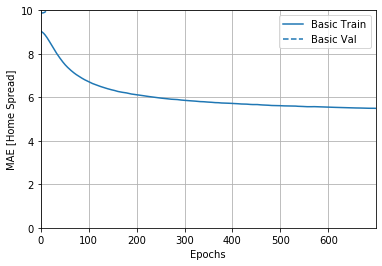

In [34]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [Home Spread]')

Text(0, 0.5, 'MSE [Spread^2]')

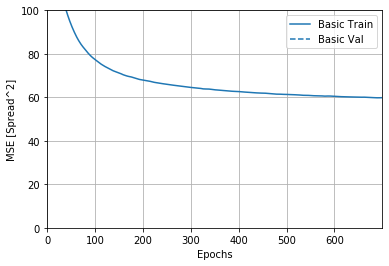

In [35]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 100])
plt.ylabel('MSE [Spread^2]')

In [36]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} Points".format(mae))

971/971 - 0s - loss: 422.0625 - mae: 16.0571 - mse: 422.0626
Testing set Mean Abs Error: 16.06 Points


### Model that stops based on improvement of MSE

In [37]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:134.4707,  mae:9.1269,  mse:134.4708,  val_loss:159.1008,  val_mae:9.8271,  val_mse:159.1008,  
...........

In [38]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} Points".format(mae))

971/971 - 0s - loss: 177.4663 - mae: 10.5381 - mse: 177.4663
Testing set Mean Abs Error: 10.54 Points


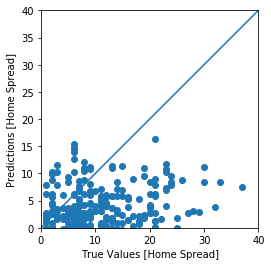

In [39]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Home Spread]')
plt.ylabel('Predictions [Home Spread]')
lims = [0, 40]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

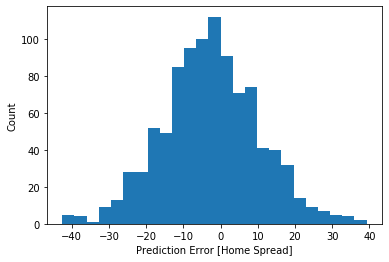

In [40]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Home Spread]")
_ = plt.ylabel("Count")

In [41]:
# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
# model.add(keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
# model.add(keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

# model.compile(optimizer='rmsprop',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# model.fit(X_train, y_train, epochs=20)

In [42]:
# val_loss, val_acc = model.evaluate(X_test, y_test)
# print(val_loss, val_acc)